In [63]:
#modules
from matplotlib import pyplot as plt
import numpy as np
import pyabf as pa
import os.path
import openpyxl as xl
import pandas as pd
from ABF_lib_Vera import *


#########################################################################################################
#open excel protocol file
pr_filename = 'protocol.xlsx'
#path = 'C:\\Users\\verat\\Documents\\Python\\BigAnalizer\\Nov16_DRUGS\\'
path = 'C:\\Users\\tsintsad\\Desktop\\BigAnalizer\\Aug31_experiment\\'
an_filename = 'analisys.xlsx'

if (os.path.isdir(path+'figs')==False):
    os.mkdir(path+'figs')
    
if (os.path.isfile(path+pr_filename)):
    protocol=pd.read_excel(path+pr_filename, sheet_name='Sheet1')
    display (protocol)
else:
        print("There's no protocol file")
# done, result - pandas dataframe


#Condition - index of protocol dataframe
A_c = {'lat_diff_treashold':[-5],'Baseline_start_sec':[0], 'Baseline_end_sec':[0.162],'Peak_find_start_sec':[0.16816], 'Peak_find_end_sec':[0.183]}
Analysis_constants = pd.DataFrame(data = A_c)

BaselineBorders = (from_secs_to_points(Analysis_constants['Baseline_start_sec'][0],50), from_secs_to_points(Analysis_constants['Baseline_end_sec'][0],50)) #to points for proper indexation 
PeakBorders = (from_secs_to_points(Analysis_constants['Peak_find_start_sec'][0],50), from_secs_to_points(Analysis_constants['Peak_find_end_sec'][0],50)) 

pdTimecourse = pd.DataFrame(columns = ['Condition','Time_sec','Filename','Sweep','Good_to_analize','Resp_Ampl','Latency','spontEPSC_freq','evokedEPSC_freq','Stim'])
pd_Res_by_file = pd.DataFrame(columns = ['Condition','Filename','Mean_Resp_Ampl','STD_Resp_Ampl','Mean_Latency','Jitter','spontEPSC_freq','evokedEPSC_freq','Stim','Comment', 'drug'])
Time_sec=0

#for each condition
for cond in protocol.index:
    from_file=protocol['from'][cond]
    to_file=protocol['to'][cond]
    Stim = float(protocol['stim'][cond])*float(protocol['X'][cond])
    filenames = from_to_filenames (from_file, to_file)
#####################################################################################################    
    #plotting trace with latency
    for file in filenames:
        data = abf_file_opener(path+file)

        #file_abs_cr_time = os.path.getmtime(file+'.abf')
        sweeps = list(range(1,data.sweepCount))
        plt.subplots(nrows=3, ncols=4)
        plt.title(file)
        for i in sweeps:
            Time_sec = Time_sec+from_points_to_secs(len(data.sweepY),50)
            ind_df=len(pdTimecourse)
            pdTimecourse.at[ind_df,'Condition']=cond
            pdTimecourse.at[ind_df,'Filename']=file
            pdTimecourse.at[ind_df,'Sweep']=i
            pdTimecourse.at[ind_df,'Stim']=Stim 
            #get responce amplitude, lattency for every sweep
            data.setSweep(i)

            resp = resp_ampl(data.sweepY, BaselineBorders, PeakBorders)    
            pdTimecourse.at[ind_df,'Resp_Ampl']=resp
            lat = lattency (data.sweepY, Analysis_constants['lat_diff_treashold'][0], PeakBorders, i)
            real_lat=from_points_to_secs(lat+PeakBorders[0], 50)-1  #counting lattency not from artifact but from 1s - by protocol, so 1 is 1s after biginning of sweep - stimulus is in 1 sec
            pdTimecourse.at[ind_df,'Latency']=real_lat
            pdTimecourse.at[ind_df,'Time_sec']=Time_sec

        # save subplot to the filename.png
        plt.title(file)
        plt.savefig( path+'figs\\cond_'+str(cond)+'_'+file+'.png')
        plt.close()
        
 ######################################################################################################   
 #user tells what to exclude from analysis , or skips
    #outliners_or_skip = input('Choose outliners? *y* or *n* or *f*:from analisys.xlsx ... ')
    outliners_or_skip='n'
    if (outliners_or_skip=='y'):
        for file in filenames:
            print(cond, file)
            outliners=list(input('what to exclude? type separated by comas ... ')) #list of sweeps-outliners for each separate file
            while (','in outliners):outliners.remove(',')
            outliners = [int(i) for i in outliners]  #no ',', everything is int
            sweeps = list(pdTimecourse.loc[pdTimecourse['Filename']==file]['Sweep'])

            for i in sweeps:

                mask = (pdTimecourse['Filename'] == file) & (pdTimecourse['Sweep'] == i)
                if ((i in outliners)==False):
                    pdTimecourse.loc[mask,'Good_to_analize']=True
                else:
                    pdTimecourse.loc[mask,'Good_to_analize']=False
    elif (outliners_or_skip=='n'):
        pdTimecourse.at[:,'Good_to_analize']=True
        
    elif (outliners_or_skip=='f'):
        
        if (os.path.isfile(path+an_filename)):
            an_res=pd.read_excel(path+an_filename, sheet_name='Timecourse')
            display (an_res)
            pdTimecourse.at[:,'Good_to_analize']=an_res['Good_to_analize'][:]
        else:
            
            print('There is no analisys file')
        break;
    else:
        print ('I dont understand')
        
    
    
 ######################################################################################################
    #filling up the result dataframe
    for file in filenames:
        ind_df=len(pd_Res_by_file)
        pd_Res_by_file.at[ind_df,'Condition']=cond
        pd_Res_by_file.at[ind_df,'Filename']=file
        mask = (pdTimecourse['Filename'] == file) & (pdTimecourse['Good_to_analize'] == True) #mask all raws where file and Good_to_analize
        pd_Res_by_file.at[ind_df,'Mean_Resp_Ampl'] = np.mean(pdTimecourse.loc[mask,'Resp_Ampl'])
        pd_Res_by_file.at[ind_df,'STD_Resp_Ampl'] = np.std(pdTimecourse.loc[mask,'Resp_Ampl'])
        pd_Res_by_file.at[ind_df,'Mean_Latency'] = np.mean(pdTimecourse.loc[mask,'Latency'])
        pd_Res_by_file.at[ind_df,'Jitter'] = np.std(pdTimecourse.loc[mask,'Latency'])
        pd_Res_by_file.at[ind_df,'Stim'] = protocol['stim'][cond]
        pd_Res_by_file.at[ind_df,'Comment'] = protocol['comment'][cond]
        pd_Res_by_file.at[ind_df,'drug'] = protocol['drug'][cond]

#display(pd_Res_by_file)

#######################################################################################################
#save to excel
writer = pd.ExcelWriter(path+an_filename)
pdTimecourse.to_excel(writer,'Timecourse')
pd_Res_by_file.to_excel(writer,'Res_by_file')
Analysis_constants.to_excel(writer,'Analysis_constants')

writer.save()
print('done')

,from,to,X,stim,comment,drug
0,learn024,learn024,0.10,0.3,short prot,NaN
1,learn025,learn025,0.10,0.1,NaN,NaN
2,learn026,learn026,0.01,0.3,NaN,NaN
3,learn027,learn027,0.01,1.0,NaN,NaN
4,learn028,learn028,0.01,2.0,NaN,NaN
5,learn029,learn029,0.01,2.6,NaN,NaN
6,learn030,learn030,0.01,2.7,NaN,NaN
7,learn031,learn031,0.01,3.0,NaN,NaN
8,learn032,learn032,0.01,3.2,NaN,NaN
9,learn033,learn033,0.01,4.0,NaN,NaN


done


In [60]:
Analysis_constants['lat_diff_treashold'][0]

-5

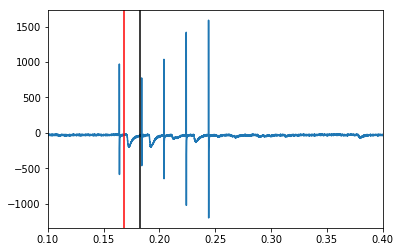

In [51]:
plt.plot(data.sweepX*4,data.sweepY)
plt.axvline(from_points_to_secs(PeakBorders[0],50), color = 'r')
plt.axvline(from_points_to_secs(PeakBorders[1],50),color = 'k')
plt.xlim(0.1,0.4)
plt.show()

In [ ]:
os.path.

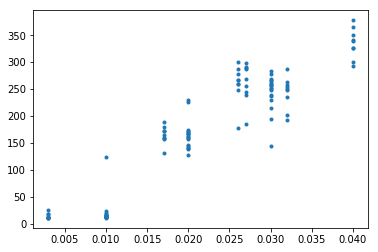

In [48]:
x_ax=pdTimecourse.loc[:]['Stim']
y_ax = pdTimecourse.loc[:]['Resp_Ampl']
plt.plot(x_ax,y_ax,'.')
plt.savefig( path+'Resp_Ampl_per_stim.png')
#plt.figure()
#y_ax = pd_Res_by_file.loc[:]['Stim']
#plt.plot(x_ax,y_ax,'o')
#plt.savefig( path+'Stim_per_file.png')

In [78]:
#
x_ax=pdTimecourse.loc[:]['Time_sec']
y_ax = pdTimecourse.loc[:]['Resp_Ampl']
y_ax_lat = pdTimecourse.loc[:]['Latency']
plt.figure()
plt.plot(x_ax/60,y_ax_lat)
plt.close()
#plt.savefig( path+'Resp_Ampl_min.png')
#plt.figure()
#plt.plot(x_ax,y_ax)
#plt.savefig( path+'Resp_Ampl_sec.png')

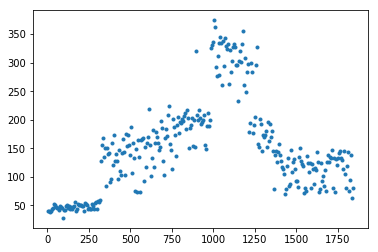

In [4]:
#Resp_Ampl for each sweep per sec
plt.plot(pdTimecourse.loc[:]['Time_sec'],pdTimecourse.loc[:]['Resp_Ampl'], '.')
plt.savefig( path+'Resp_Ampl_sec.png')

(1.095, 1.11)

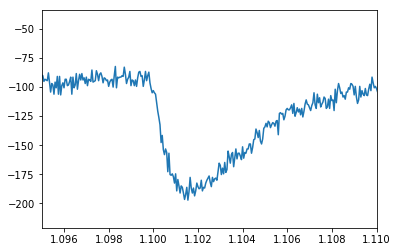

In [20]:
data.setSweep(1)
plt.plot(data.sweepX*4,data.sweepY)
plt.xlim(1.095,1.11)

In [8]:
file

'l868'